# Problem Set 5
In this problem set you will implement the Conditional Gradient algorithm, also known as the Frank Wolfe algorithm, and you will compare it to algiorithms you have implemented on previous homeworks. You will also play with Mirror Descent.

# Problem 1: LASSO via Frank Wolfe
Recall the least squares problem with $\ell^1$ regularization from the previous two homeworks:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

So far you have used the subgradient method, ISTA and FISTA (proxima gradient, and accelerated proximal gradient) to solve this problem. Now you will use Frank-Wolfe.

As we cover in the lectures, the Frank-Wolfe (or conditional gradient) algorithm minimizes a smooth function $f(x)$ subject to a convex constraint $x \in \mathcal{X}$.

When it is easy to minimize a linear function over $\mathcal{X}$, Frank-Wolfe (FW) has several advantages including that it often produces sparse iterates and does not require a projection step to stay within $\mathcal{X}$. In order to apply FW to the LASSO problem above, we can reformulate the problem as

\begin{eqnarray*}
\min_{{x}}: && \frac{1}{2}\|A{x}-{b}\|_2^2, \\
\mbox{s.t. } && \|{x}\|_1 \leq \gamma.
\end{eqnarray*}

This formulation is equivalent to the original LASSO formulation for a suitable value of $\gamma$ (and depending on the $\lambda$ in the original LASSO formulation).

Run the FW algorithm for $10^4$ steps and find a $\gamma$ that performs well empirically (you might consider the $\ell^1$ norm of your solution from previous homework. Compare the results to sub-gradient method implemented in the previous homework. Again, separately record the (unsquared) error $\|A{x}_t-{b}\|$ and the regularization term $\|{x}\|_1$.

In [1]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

A = np.load("A.npy")
b = np.load("b.npy")

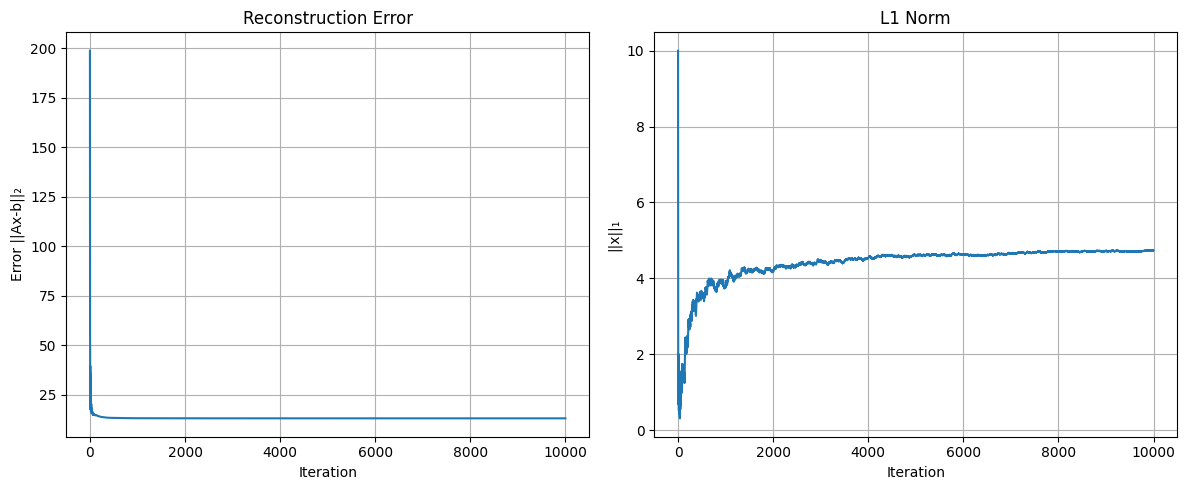

In [2]:
def frank_wolfe_lasso(A, b, gamma, max_iter=10000):
    # Initialize
    n = A.shape[1]
    x = np.zeros(n)
    
    # Lists to store metrics
    errors = []
    l1_norms = []
    
    for t in range(max_iter):
        # Compute gradient: A^T(Ax - b)
        grad = A.T @ (A @ x - b)
        
        # Find s_t: argmin_{||s||₁ ≤ γ} <grad, s>
        # This has a closed form solution:
        # Put -γ in the coordinate of maximum magnitude gradient
        idx = np.argmax(np.abs(grad))
        s = np.zeros(n)
        s[idx] = -gamma if grad[idx] > 0 else gamma
        
        # Step size: 2/(t+2) is a standard choice for FW
        step_size = 2.0 / (t + 2)
        
        # Update: x_{t+1} = (1-step_size)x_t + step_size*s_t
        x = (1 - step_size) * x + step_size * s
        
        # Record metrics
        errors.append(np.linalg.norm(A @ x - b))
        l1_norms.append(np.linalg.norm(x, ord=1))
    
    return x, errors, l1_norms

# Run the algorithm
gamma = 10.0  # You may need to tune this value
x_fw, errors_fw, l1_norms_fw = frank_wolfe_lasso(A, b, gamma)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(errors_fw)
plt.xlabel('Iteration')
plt.ylabel('Error ||Ax-b||₂')
plt.title('Reconstruction Error')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(l1_norms_fw)
plt.xlabel('Iteration')
plt.ylabel('||x||₁')
plt.title('L1 Norm')
plt.grid(True)

plt.tight_layout()
plt.show()

#Problem 2: Robust Regression, PSGD and Mirror Descent
Consider the problem of robust regression, where some small number of measurements have been potentially completely corrupted. One way to formulate an optimization problem to solve this robust regression is as follows:

\begin{eqnarray*}
\min_{\beta}: && \|X \beta - \mathbf{y}\|_1 \\
{\rm s.t.}: && \beta \in \mathcal{X}.
\end{eqnarray*}

The rationale for this formulation stems from the idea that because of the $\ell^1$-error, huge errors are not disproportionally penalized, as they would be in the squared error formulation (this is the formulation we have worked with before, including in the previous problem), and therefore the optimal solution is less sensitive to outliers. You will solve this problem using Projected Subgradient Descent, and also Mirror Descent. Let the constraint set be the simplex:
$$
\mathfrak{X} = \{\beta \,:\, \beta \geq 0, \, \sum \beta_i = 1\}.
$$





##Part (A)
Write down the update for projected gradient descent.

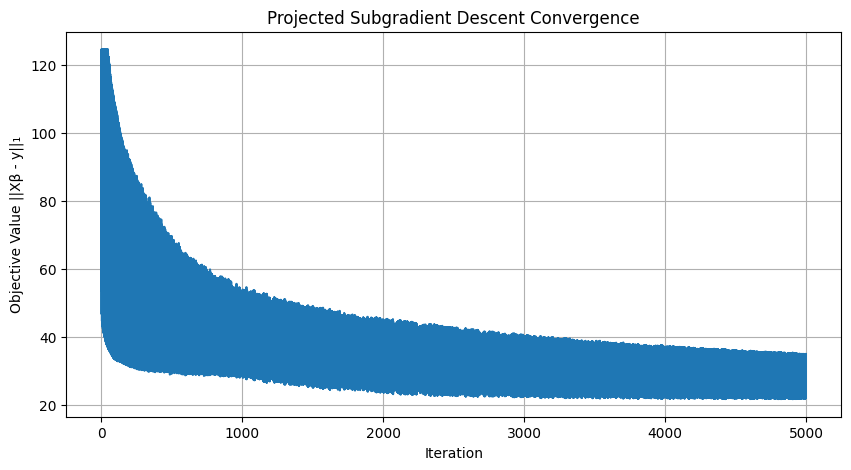

Final objective value: 34.8984


In [8]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

# Load the data
X = np.load("X.npy")
y = np.load("y.npy")

def project_simplex(v):
    """Project vector v onto the probability simplex."""
    n = len(v)
    # Sort v into u in descending order
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - 1
    rho = np.nonzero(u * np.arange(1, n+1) > cssv)[0][-1]
    theta = cssv[rho] / (rho + 1)
    return np.maximum(v - theta, 0)

def subgradient_sign(x):
    """Compute sign subgradient of L1 norm at x."""
    return np.sign(x)

def robust_regression_psgd(X, y, max_iter=5000, initial_lr=0.1):
    n_features = X.shape[1]
    beta = np.ones(n_features) / n_features  # Initialize at center of simplex
    
    # Store the objective values
    objectives = []
    
    for t in range(max_iter):
        # Decreasing learning rate schedule
        learning_rate = initial_lr / np.sqrt(t + 1)
        
        # Compute residual
        residual = X @ beta - y
        
        # Compute subgradient of L1 loss
        subgrad = X.T @ subgradient_sign(residual)
        
        # Gradient step
        beta_new = beta - learning_rate * subgrad
        
        # Project onto probability simplex
        beta = project_simplex(beta_new)
        
        # Record objective value
        obj_value = np.sum(np.abs(X @ beta - y))
        objectives.append(obj_value)
        
        # Optional: Early stopping if converged
        if t > 0 and abs(objectives[-1] - objectives[-2]) < 1e-8:
            print(f"Converged at iteration {t}")
            break
    
    return beta, objectives

# Run the algorithm
beta_psgd, obj_psgd = robust_regression_psgd(X, y)

# Plot the convergence
plt.figure(figsize=(10, 5))
plt.plot(obj_psgd)
plt.xlabel('Iteration')
plt.ylabel('Objective Value ||Xβ - y||₁')
plt.title('Projected Subgradient Descent Convergence')
plt.grid(True)
plt.show()

# Print final objective value
print(f"Final objective value: {obj_psgd[-1]:.4f}")

##Part (B)
Write down the mirror descent update. For this, we will use the mirror map $\Phi(\beta) = \sum \beta_i \log \beta_i$. Compute the Bregman divergence, $D_{\phi}(\mathbf{\beta},\mathbf{z})$ explicitly. <br>
(We use $\mathbf{z}$ here to not confuse this variable with $\mathbf{y}$ in the robust regression problem above. $\mathbf{z}$ is the intermediate term used in Mirror Descent, which was commonly denoted as $\mathbf{y}$ in the lectures.)

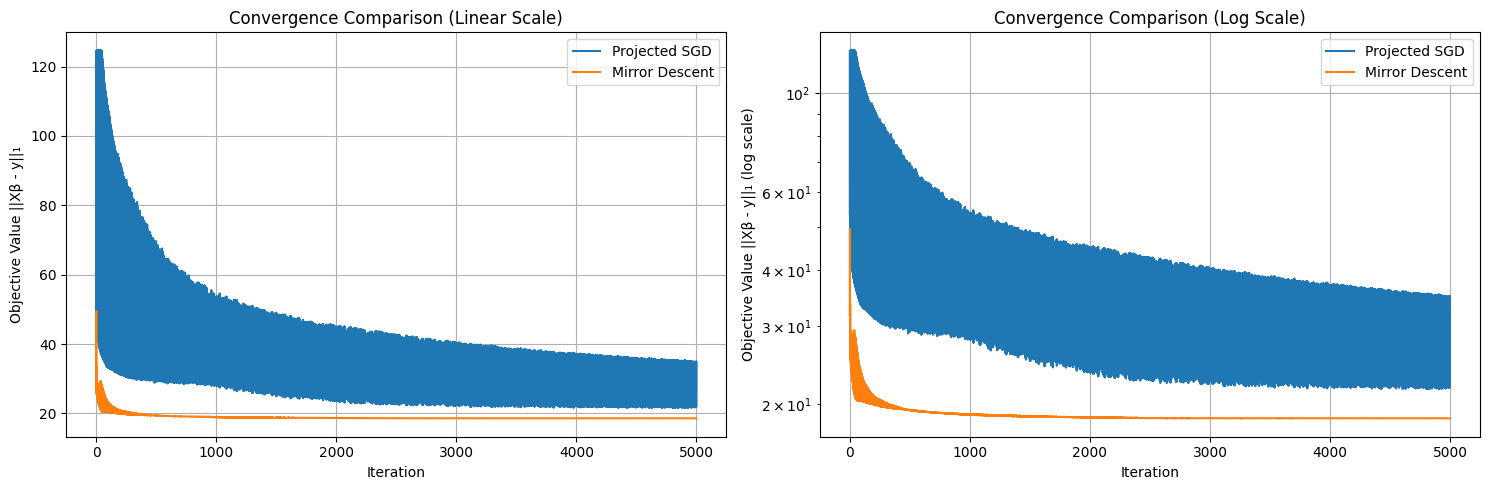

Projected SGD final objective: 34.89841076111401
Mirror Descent final objective: 18.572096898284617


In [10]:
def mirror_map(beta):
    """Compute the mirror map Φ(β) = Σ βᵢ log βᵢ"""
    # Handle 0 * log(0) = 0 case
    mask = beta > 0
    result = np.zeros_like(beta)
    result[mask] = beta[mask] * np.log(beta[mask])
    return np.sum(result)

def mirror_gradient(beta):
    """Compute gradient of mirror map: 1 + log(β)"""
    return 1 + np.log(beta)

def inverse_mirror_gradient(x):
    """Compute inverse of mirror map gradient: exp(x-1)"""
    return np.exp(x - 1)

def bregman_divergence(beta, z):
    """Compute Bregman divergence D_φ(β,z)"""
    phi_beta = mirror_map(beta)
    phi_z = mirror_map(z)
    grad_phi_z = mirror_gradient(z)
    return phi_beta - phi_z - np.sum(grad_phi_z * (beta - z))

def robust_regression_mirror_descent(X, y, max_iter=5000, initial_lr=0.1):
    n_features = X.shape[1]
    beta = np.ones(n_features) / n_features  # Initialize at center of simplex
    
    # Store the objective values
    objectives = []
    
    for t in range(max_iter):
        # Decreasing learning rate schedule
        learning_rate = initial_lr / np.sqrt(t + 1)
        
        # Compute residual and subgradient
        residual = X @ beta - y
        subgrad = X.T @ subgradient_sign(residual)
        
        # Mirror Descent update:
        # 1. Compute gradient step in dual space
        dual_var = mirror_gradient(beta) - learning_rate * subgrad
        # 2. Map back to primal space
        beta_new = inverse_mirror_gradient(dual_var)
        # 3. Project onto simplex (using normalization for probability simplex)
        beta = beta_new / np.sum(beta_new)
        
        # Record objective value
        obj_value = np.sum(np.abs(X @ beta - y))
        objectives.append(obj_value)
        
        # Optional: Early stopping if converged
        if t > 0 and abs(objectives[-1] - objectives[-2]) < 1e-8:
            print(f"Converged at iteration {t}")
            break
    
    return beta, objectives

# Run both algorithms and compare
beta_psgd, obj_psgd = robust_regression_psgd(X, y)
beta_md, obj_md = robust_regression_mirror_descent(X, y)

# Plot comparison
plt.figure(figsize=(15, 5))

# Linear scale comparison
plt.subplot(1, 2, 1)
plt.plot(obj_psgd, label='Projected SGD')
plt.plot(obj_md, label='Mirror Descent')
plt.xlabel('Iteration')
plt.ylabel('Objective Value ||Xβ - y||₁')
plt.title('Convergence Comparison (Linear Scale)')
plt.legend()
plt.grid(True)

# Log scale comparison
plt.subplot(1, 2, 2)
plt.plot(obj_psgd, label='Projected SGD')
plt.plot(obj_md, label='Mirror Descent')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective Value ||Xβ - y||₁ (log scale)')
plt.title('Convergence Comparison (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final results comparison
print("Projected SGD final objective:", obj_psgd[-1])
print("Mirror Descent final objective:", obj_md[-1])

##Part (C)
Using the data in X.npy and y.npy, and using stepsizes of your choosing, compare the projected subgradient method with mirror descent. What is $\beta$? Plot the objective above against iterations for both methods (in a single plot).

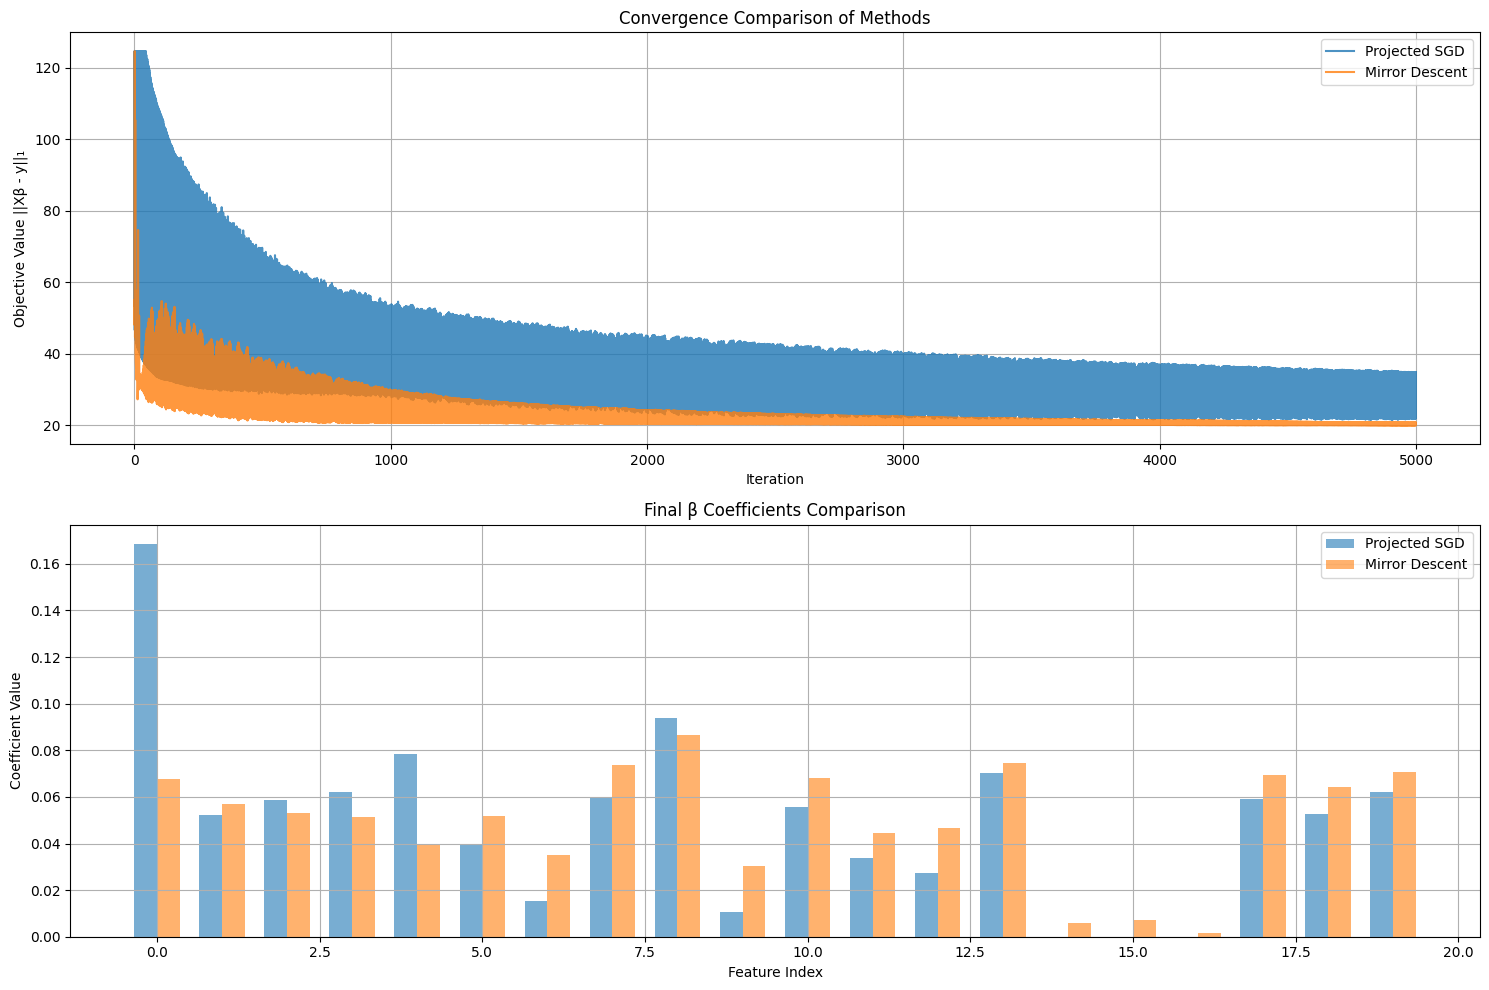


Comparison Metrics:
--------------------------------------------------
Final objective (PSGD): 34.8984
Final objective (Mirror): 20.7990

Non-zero coefficients (PSGD): 17
Non-zero coefficients (Mirror): 20

Max coefficient (PSGD): 0.1683
Max coefficient (Mirror): 0.0865

Min non-zero coefficient (PSGD): 0.0107
Min non-zero coefficient (Mirror): 0.0017

Correlation between solutions: 0.7246


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
X = np.load("X.npy")
y = np.load("y.npy")

# Run both algorithms with same number of iterations but potentially different learning rates
max_iter = 5000
beta_psgd, obj_psgd = robust_regression_psgd(X, y, max_iter=max_iter, initial_lr=0.1)
beta_md, obj_md = robust_regression_mirror_descent(X, y, max_iter=max_iter, initial_lr=0.5)  # Mirror descent often allows larger learning rates

# Create comparison plots
plt.figure(figsize=(15, 10))

# Plot 1: Objective value convergence
plt.subplot(2, 1, 1)
plt.plot(obj_psgd, label='Projected SGD', alpha=0.8)
plt.plot(obj_md, label='Mirror Descent', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Objective Value ||Xβ - y||₁')
plt.title('Convergence Comparison of Methods')
plt.legend()
plt.grid(True)

# Plot 2: Final beta values comparison
plt.subplot(2, 1, 2)
width = 0.35
x = np.arange(len(beta_psgd))
plt.bar(x - width/2, beta_psgd, width, label='Projected SGD', alpha=0.6)
plt.bar(x + width/2, beta_md, width, label='Mirror Descent', alpha=0.6)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Final β Coefficients Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print comparison metrics
print("\nComparison Metrics:")
print("-" * 50)
print(f"Final objective (PSGD): {obj_psgd[-1]:.4f}")
print(f"Final objective (Mirror): {obj_md[-1]:.4f}")
print(f"\nNon-zero coefficients (PSGD): {np.sum(beta_psgd > 1e-6)}")
print(f"Non-zero coefficients (Mirror): {np.sum(beta_md > 1e-6)}")
print(f"\nMax coefficient (PSGD): {np.max(beta_psgd):.4f}")
print(f"Max coefficient (Mirror): {np.max(beta_md):.4f}")
print(f"\nMin non-zero coefficient (PSGD): {np.min(beta_psgd[beta_psgd > 1e-6]):.4f}")
print(f"Min non-zero coefficient (Mirror): {np.min(beta_md[beta_md > 1e-6]):.4f}")

# Compute correlation between the two solutions
correlation = np.corrcoef(beta_psgd, beta_md)[0,1]
print(f"\nCorrelation between solutions: {correlation:.4f}")